# Import Libraries

In [2]:
# custom function for time series statistics
import custom_functions.time_series_functions as tsf

# to add holidays features
import holidays

# Data visualisations
import matplotlib.pyplot as plt

# Base libraries
import numpy as np
import pandas as pd

# More data viz
import plotly.express as px
import seaborn as sns

# to use pandas dtypes in matplotlib plots
from pandas.plotting import register_matplotlib_converters

# rich
from rich.console import Console

console = Console()

register_matplotlib_converters()

# set plotly as automatick backend for plot wih pandas
pd.options.plotting.backend = "plotly"

# create a dict to update plotly layout
plotly_styles = dict(
    font_family="DejaVuSansMono Nerd Font",
    template="none",
    title={
        "x": 0.05,
        # basically, what part of the title to put at position "x"
        "xanchor": "left",
    },
)


# set settings for seaborn
sns.set_style(style="darkgrid", rc={"axes.facecolor": ".9", "grid.color": ".8"})
sns.set_palette(palette="deep")
sns_c = sns.color_palette(palette="deep")  # will be useful later

# visualise plots inline
%matplotlib inline

# customise matplotlib and sns plot dimensions
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100

# Load Data and Preprocessing

In [3]:
daily_outflow = pd.read_csv("../data/bikemi_csv/daily_outflow.csv", parse_dates=[0])

daily_outflow = (
    daily_outflow.assign(
        year=lambda x: x["giorno_partenza"].dt.year,
        month=lambda x: x["giorno_partenza"].dt.month,
        month_name=lambda x: x["giorno_partenza"].dt.month_name().astype("category"),
        week=lambda x: x["giorno_partenza"].dt.isocalendar().week,
        day=lambda x: x["giorno_partenza"].dt.weekday,
        day_name=lambda x: x["giorno_partenza"].dt.day_name(),
        day_of_month=lambda x: x["giorno_partenza"].dt.day,
        dayofyear=lambda x: x["giorno_partenza"].dt.dayofyear,
        # alternatively:
        # holiday = lambda ts: list(map(lambda x: holidays.CountryHoliday("IT").get(x), ts["giorno_partenza"]))
        holiday=lambda ts: ts["giorno_partenza"].apply(
            lambda x: holidays.CountryHoliday("IT").get(x)
        ),
    )
    .set_index("giorno_partenza")
    .astype({"day_name": "category", "holiday": "category"})
)

daily_outflow.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   count         365 non-null    int64   
 1   year          365 non-null    int64   
 2   month         365 non-null    int64   
 3   month_name    365 non-null    category
 4   week          365 non-null    UInt32  
 5   day           365 non-null    int64   
 6   day_name      365 non-null    category
 7   day_of_month  365 non-null    int64   
 8   dayofyear     365 non-null    int64   
 9   holiday       12 non-null     category
dtypes: UInt32(1), category(3), int64(6)
memory usage: 23.9 KB


# Basic Plotting

## Time Series Plot

In [4]:
daily_outflow.plot(
    y="count",
    title="BikeMi Daily Rentals, 2019",
    color_discrete_sequence=px.colors.qualitative.T10,
).update_layout(**plotly_styles).update_traces(hovertemplate=None)

It is clear that the series is non-stationary and displays strong seasonal patterns. We can perform a Dickey-Fuller test to ensure this:

## Rolling Statistics

In [5]:
daily_outflow.plot(
    y=[
        "count",
        daily_outflow["count"].rolling(7).mean(),
        daily_outflow["count"].rolling(7).std(),
    ],
    title="Daily Rentals with Rolling Statistics (Window Size: 7)",
    color_discrete_sequence=px.colors.qualitative.Pastel,
).update_layout(**plotly_styles).update_traces(hovertemplate=None)

In [6]:
daily_outflow.plot(
    y=[
        "count",
        daily_outflow["count"].rolling(30).mean(),
        daily_outflow["count"].rolling(30).std(),
    ],
    title="Daily Rentals with Rolling Statistics (Window Size: 30)",
    color_discrete_sequence=px.colors.qualitative.Pastel,
).update_layout(**plotly_styles).update_traces(hovertemplate=None)

The most relevant thing about these statistics is that the seasonal component of the time series does not really smooth out even with a 30 days lag, suggesting a strong dependence even with past lags.

Given this distribution, we expect a strong relationship between data points that are seven lags from each other. More importantly, we expect that this variance will hinder the accuracy of our forecasts. This may require transforming the data (e.g. by taking logs or applying a Box-Cox transformation and searching for the optimal parameter $\lambda$) or *decomposing the time series*.

We can also make a pretty plot to export:

Text(0.5, 1.02, 'Bikemi Rentals (Daily) - Smooth Moving Average')

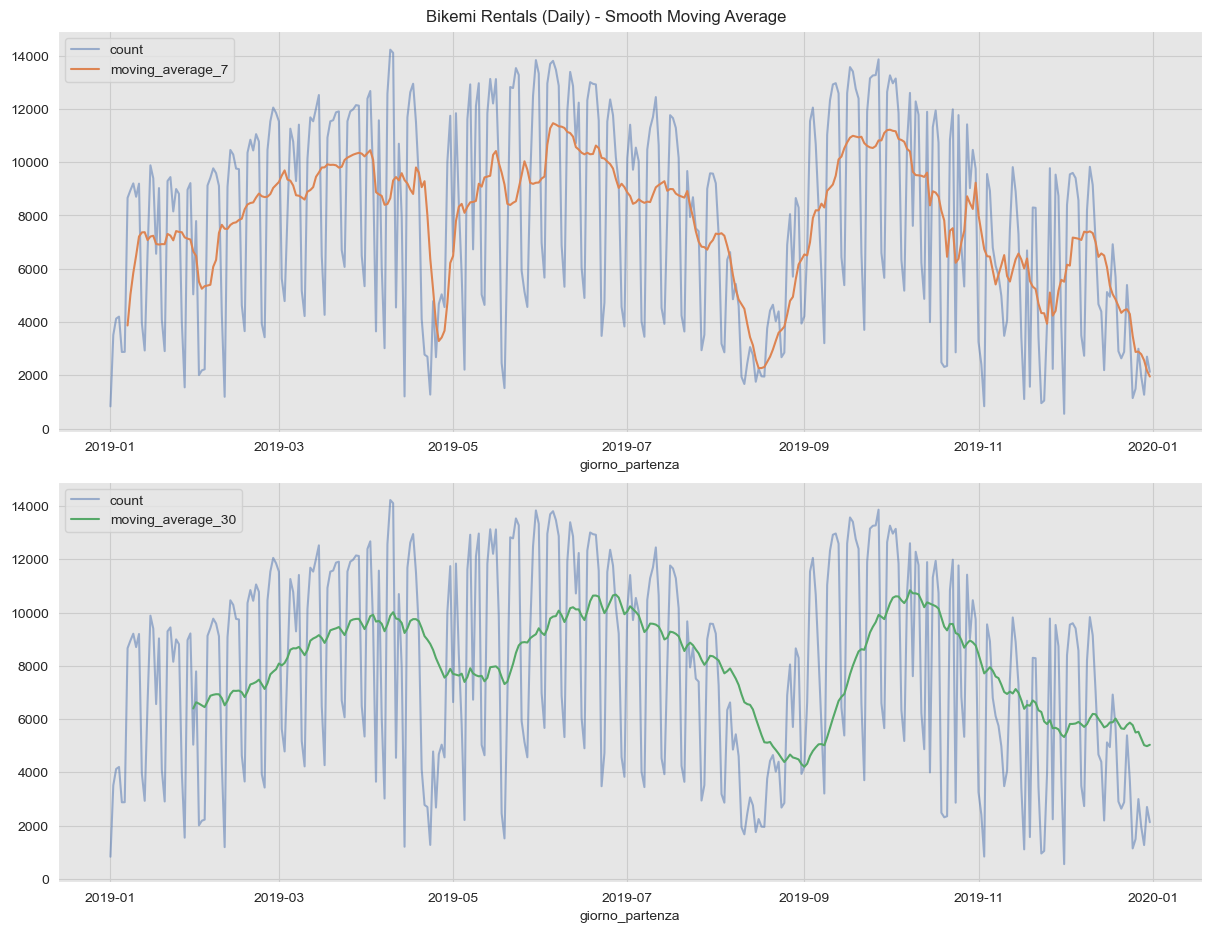

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(12, 9), constrained_layout=True)

# create the windows
ma = [7, 30]

for i, m in enumerate(ma):

    daily_outflow[f"moving_average_{m}"] = (
        daily_outflow["count"].rolling(window=m).mean()
    )

    sns.lineplot(
        x=daily_outflow.index,
        y="count",
        label="count",
        data=daily_outflow,
        alpha=0.5,
        ax=ax[i],
    )
    sns.lineplot(
        x=daily_outflow.index,
        y=f"moving_average_{m}",
        label=f"moving_average_{m}",
        data=daily_outflow,
        color=sns_c[i + 1],
        ax=ax[i],
    )
    ax[i].legend(loc="upper left")
    ax[i].set(title="", ylabel="")
plt.suptitle("Bikemi Rentals (Daily) - Smooth Moving Average", y=1.02)

## Seasonal Plots

In [8]:
# play with color palettes: https://plotly.com/python/discrete-color/

pd.pivot_table(
    data=daily_outflow[["day_name", "month_name", "count"]],
    index="day_name",
    columns="month_name",
)["count"].plot(color_discrete_sequence=px.colors.qualitative.Dark24).update_layout(
    **plotly_styles
).update_traces(
    hovertemplate=None
)

# Transforming the Data

## First Differences

We can also plot the first differences or the seasonal differences to see how the data transforms:

In [9]:
daily_outflow.plot(
    y=daily_outflow["count"].diff(),
    color_discrete_sequence=px.colors.qualitative.Pastel,
    title="BikeMi Daily Rentals, First Differences (2019)",
).update_layout(**plotly_styles).update_traces(hovertemplate=None)

The data seems stationary, but still displays a strong seasonality and a great variance. This suggests that performing an ARIMA might not actually prove useful - a SARIMA could indeed yield better results. Let's see what comes out with seasonal differences, i.e. subtracting the value of 7 days before.

## Seasonal Differencing

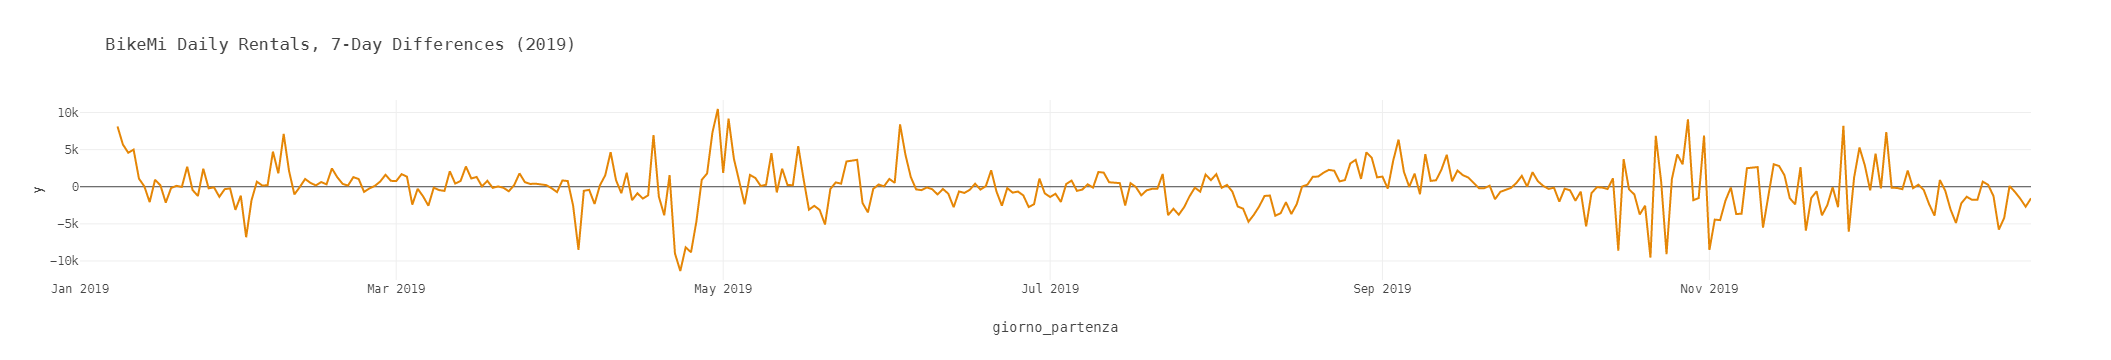

In [10]:
daily_outflow.plot(
    y=daily_outflow["count"].diff(7),
    color_discrete_sequence=px.colors.qualitative.Vivid,
    title="BikeMi Daily Rentals, 7-Day Differences (2019)",
).update_layout(**plotly_styles).update_traces(hovertemplate=None)

This seemingly removes any seasonality and leaves us with a lot of variance, still. We can use our human knowledge to explain some of this variation: holidays, first of all. Then we would expect the temperature to play a role, in conjunction with precipitation (i.e. the winter), which could explain the greater variance around the last months of the year.

This suggests that even a SARIMA model might not compete with something like Prophet, which can exploit holiday patterns. However, without the aid of external data, neither of the two models can take into account rainy days or colder weather - even via categorical variables such as dummies for each month.

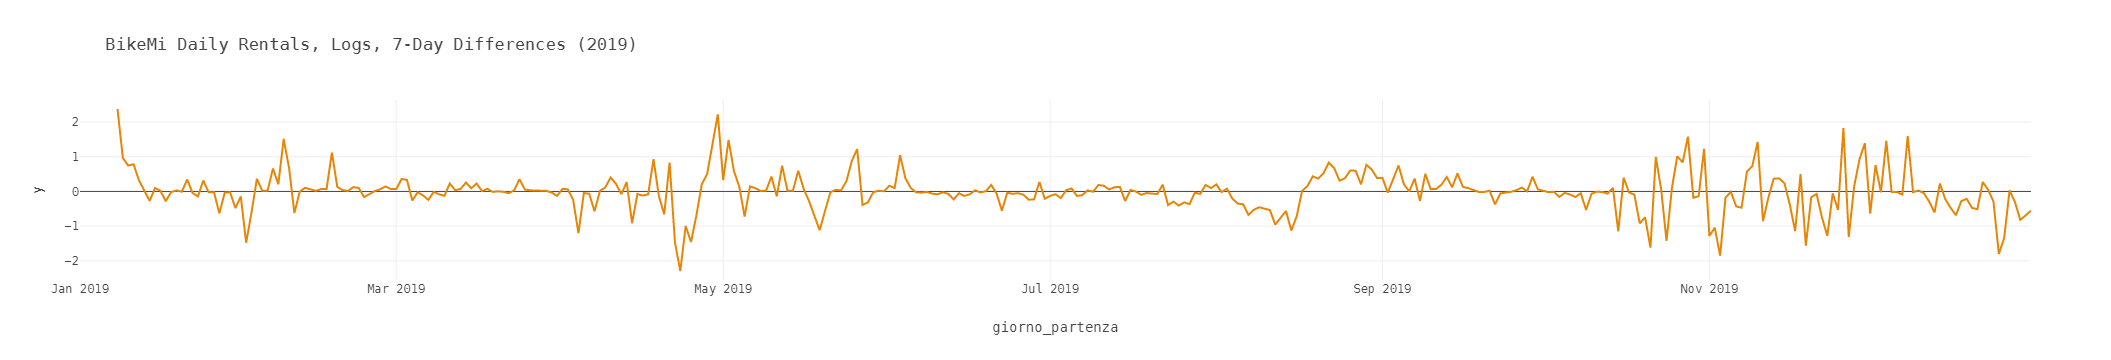

In [11]:
import numpy as np

daily_outflow.plot(
    y=daily_outflow["count"].apply(np.log).diff(7),
    color_discrete_sequence=px.colors.qualitative.Vivid,
    title="BikeMi Daily Rentals, Logs, 7-Day Differences (2019)",
).update_layout(**plotly_styles).update_traces(hovertemplate=None)

When we apply a log-transformation to the data, variance reduces a bit (as the differences between two consecutive observations decrease).

# Time Series Decomposition

Here we perform some elementary time series decomposition. As of now, the aim of this part is to simply get an idea of the components of our target time series, rather then performing a satisfactory and state-of-the-art decomposition. More advanced techniques are recommended, instead of elementary `additive` and `multiplicative` decomposition.

[Text(0.5, 1.0, 'residual'), Text(0.5, 0, '')]

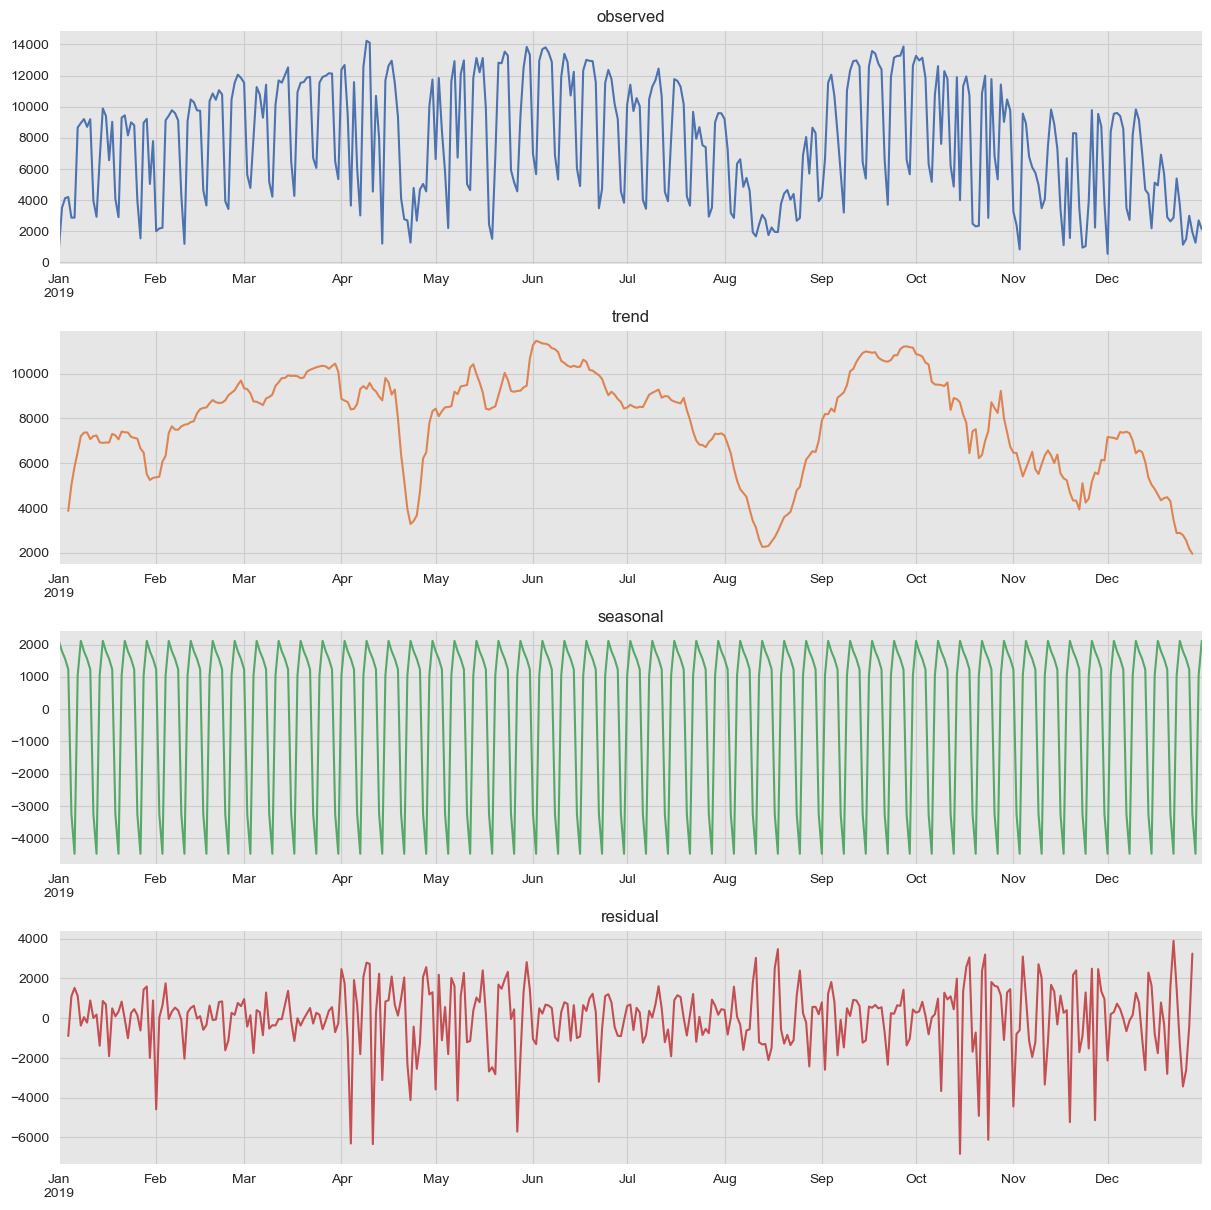

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

# We use the parameter `period` = 365 to extract the yearly seasonality.
weekly_seasonal_decomposition = seasonal_decompose(
    x=daily_outflow["count"], model="additive", period=7
)

pd.options.plotting.backend = "matplotlib"
fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

weekly_seasonal_decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title="observed", xlabel="")
weekly_seasonal_decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title="trend", xlabel="")
weekly_seasonal_decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title="seasonal", xlabel="")
weekly_seasonal_decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title="residual", xlabel="")

We choose the `additive` decomposition instead of the `multiplicative` as the seasonal component does not appear to be increasing as a function of the trend one.

## Testing for Stationarity

Two tests are employed: the Augmented Dickey-Fuller and the KPSS test.

* The Dickey-Fuller test's null hypothesis is that there is a unit root, i.e. is non-stationary.
* The KPSS test's null hypothesis is that the series is level or trend stationary.

The KPSS test differs from the Dickey-Fuller: its null hypothesis is the "opposite" of the Dickey-Fuller and we have to be more careful in how we read the test statistics or the p-value.

For the Dickey-Fuller, a p-value greater than 5% will indicate that we fail to reject the null hypothesis that there is a unit root - in other words, the series is non-stationary. The KPSS test's null hypothesis (not rejected when the p-value is greater than 5) is that the series is level or trend-stationary. In other words, **contrary to the ADF test, the non-stationarity is the alternative hypothesis**.

In other words, we expect the ADF p-value to be greater than the significance threshold and the KPSS one to be smaller.

In [13]:
from statsmodels.tsa.stattools import adfuller, kpss

adfuller_results = adfuller(daily_outflow["count"], regression="ct")
kpss_results = kpss(daily_outflow["count"], regression="ct", nlags="auto")


console.print(
    f"""
Advanced Dickey-Fuller p-value is {adfuller_results[1]:.2%}: \
{"there is a unit root - i.e. the series is non-stationary" if adfuller_results[1] > 0.05 else "there is no unit root - the series is stationary"}.
KPSS p-value is {kpss_results[1]:.2%}: \
{"the series is stationary (there is no unit root)" if kpss_results[1] > 0.05 else "the series is non-stationary (there is a unit root)"}.
    """
)

C:\Anaconda3\envs\bikemi_win\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




Advanced Dickey-Fuller p-value is 30.03%: there is a unit root - i.e. the series is 
non-stationary.
KPSS p-value is 1.00%: the series is non-stationary (there is a unit root).

Using the `auto` procedure for selecting the number of lags (`nlags`) of the KPSS test returns a warning: `The actual p-value is smaller than the p-value returned`. The KPSS 

# Autocorrelation and Partial Autocorrelation Plots

The exploratory analysis showed a strong seasonality in the data: let's see it with autocorrelation plots.

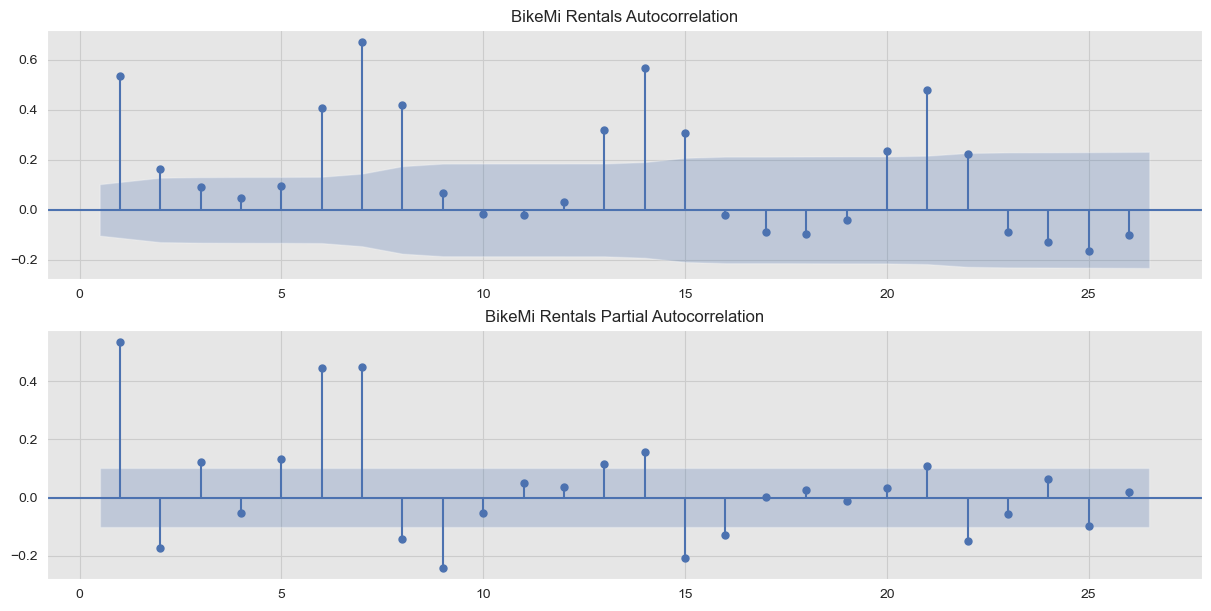

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, constrained_layout=True)
plot_acf(
    x=daily_outflow["count"],
    ax=ax[0],
    title="BikeMi Rentals Autocorrelation",
    zero=False,
)
plot_pacf(
    x=daily_outflow["count"],
    ax=ax[1],
    title="BikeMi Rentals Partial Autocorrelation",
    zero=False,
);

These plots show us that there is a strong and significant autocorrelation until at least the 30th lag. This fact should not be too surprising: we could already spot it from the 30 day window moving average, but is still remarkable. This will likely entail a greater MA component for our (S)ARIMA models.

Partial autocorrelation displays another strong link with seasonality: statistically speaking, there is correlation with the residuals at the 14th to 16th lag - and arguably even beyond. We also expect an AR component for our models.

The declining autocorrelation not only displays a strong seasonal pattern, but also a trend.

As explained in the [official documentation](https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.arima.AutoARIMA.html?highlight=seasonal%20decomposition),

The auto-ARIMA process seeks to identify the most optimal parameters for an ARIMA model, settling on a single fitted ARIMA model. This process is based on the commonly-used R function, forecast::auto.arima [3].

Auto-ARIMA works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto-ARIMA also seeks to identify the optimal P and Q hyper-parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

In order to find the best model, auto-ARIMA optimizes for a given information_criterion, one of (‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’) (Akaike Information Criterion, Corrected Akaike Information Criterion, Bayesian Information Criterion, Hannan-Quinn Information Criterion, or “out of bag”–for validation scoring–respectively) and returns the ARIMA which minimizes the value.

Note that due to stationarity issues, auto-ARIMA might not find a suitable model that will converge. If this is the case, a ValueError will be thrown suggesting stationarity-inducing measures be taken prior to re-fitting or that a new range of order values be selected. Non- stepwise (i.e., essentially a grid search) selection can be slow, especially for seasonal data. Stepwise algorithm is outlined in Hyndman and Khandakar (2008).